# ShallowCNN

In [ ]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

### Load the data

In [ ]:
path_to_data = '.' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape

### Creating the model

We first create a dataloader

In [9]:
# Turn the different sets of data into dataloaders
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

batch_size = 32

class ITDataset(Dataset):
    def __init__(self, stimuli, spikes, transform=None):
        self.stimuli = stimuli
        self.spikes = spikes
        self.transform = transform

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimulus = self.stimuli[idx]
        spike = self.spikes[idx]

        if self.transform:
            stimulus = self.transform(stimulus)

        return stimulus, spike
    
# Normalize the stimuli (already normalized?)
mean = np.mean(stimulus_train)
std = np.std(stimulus_train)
print('The mean of the training set is {}'.format(mean))
print('The std of the training set is {}'.format(std))

stimulus_train_norm = (stimulus_train - mean) / std
stimulus_val_norm = (stimulus_val - mean) / std
mean_val_norm = np.mean(stimulus_val_norm)
std_val_norm = np.std(stimulus_val_norm)
print('The std of the validation set is {} after normalization'.format(std_val_norm))
print('The mean of the validation set is {} after normalization'.format(mean_val_norm))

# Define dataset and loader
dataset_train = ITDataset(stimuli=stimulus_train, spikes=spikes_train)
dataset_val = ITDataset(stimuli=stimulus_val, spikes=spikes_val)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test loader, begin with only 100 training samples to test the code
small_dataset_train = ITDataset(stimuli=stimulus_train[:100], spikes=spikes_train[:100])
small_dataset_val = ITDataset(stimuli=stimulus_val[:100], spikes=spikes_val[:100])
small_train_loader = DataLoader(small_dataset_train, batch_size=batch_size, shuffle=True)
small_val_loader = DataLoader(small_dataset_val, batch_size=batch_size, shuffle=False)

The mean of the training set is -0.010786568745970726
The std of the training set is 0.8106227517127991
The std of the validation set is 0.9952276945114136 after normalization
The mean of the validation set is 0.02567381225526333 after normalization


We then define the model: a shallow CNN with a block representing 3 layers.

In [ ]:
num_neurons = spikes_train.shape[1]  # Number of neurons

class ShallowConvNetBlock(nn.Module):
    def __init__(self, dim, kernel_size=7, add_pool=False):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size//2, groups=dim)  # Depthwise conv
        self.norm = nn.LayerNorm(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # Pointwise expansion
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)  # Pointwise contraction
        self.gamma = nn.Parameter(1e-6 * torch.ones(dim))  # LayerScale

    def forward(self, x):
        residual = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (B, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (B, C, H, W)
        x += residual
        return x
    
class ShallowConvNet(nn.Module):
    def __init__(self, in_channels=3, dims=[64, 64], kernel_sizes=[7, 7]):      # here modify the nb of channels
        super().__init__()
        self.stem = nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4)  # Patchify
        self.blocks = nn.Sequential(
            *[ShallowConvNetBlock(dim=d, kernel_size=k) 
              for d, k in zip(dims, kernel_sizes)]
        )
        self.head = nn.Linear(dims[-1], num_neurons)  # Predict neural activity

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = x.mean(dim=[2, 3])  # Global average pooling
        return self.head(x)

Define the trainer

In [11]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.best_val_loss = float('inf')

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for x, y in tqdm(self.train_loader, desc="Training"):
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(x)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in tqdm(self.val_loader, desc="Validation"):
                x, y = x.to(self.device), y.to(self.device)
                outputs = self.model(x)
                val_loss += self.criterion(outputs, y).item()
        return val_loss / len(self.val_loader)

    def fit(self, epochs, early_stopping_patience=5):
        for epoch in range(epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate()
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), f'best_model{len(self.model.blocks)}_blocks.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered!")
                    break
        

## Training a 1-block model

For the training, we'll use Mean Squared Error (MSE) loss, and the Adam optimizer with weight decay. We begin by training a 1-block model (3-layers).

There are many hyperparameters or choice that we could study to find the best combination: the choice of the loss, of the optimizer, of the filter sizes, the number of channels, etc.

Due to computing limitations, here we'll perform only a quick testing of the two latter hyperparameters.

### Testing different filter sizes

We should expect that increasing the filter size leads to better results. However, it should saturate at some point. This saturation we want to explore, to find the most reasonable filter size that leads to good results.

In [ ]:
### Test different filter sizes
filter_sizes_to_test = [3, 5, 7, 9, 11]

results_filter_sizes = {}

for filter_size in filter_sizes_to_test:
    print(f"\n=== Training with filter size {filter_size} ===")
    
    # Define model with the given filter size
    model = ShallowConvNet(dims=[64], kernel_sizes=[filter_size])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Create a new trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device='cuda'
    )

    # Train
    trainer.fit(epochs=10, early_stopping_patience=5)

    # Evaluate on validation set
    model_name = f'best_model{len(model.blocks)}_blocks.pth'
    model.load_state_dict(torch.load(model_name))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to('cuda')
            preds = model(x)
            y_pred.append(preds.cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)

    # Compute metrics
    corr_filter_sizes = pearsonr(spikes_val, y_pred)
    mse_filter_sizes = mean_squared_error(spikes_val, y_pred)
    ev_filter_sizes = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')

    results_filter_sizes[filter_size] = {
        'corr': corr_filter_sizes,
        'mse': mse_filter_sizes,
        'ev': ev_filter_sizes,
        'y_pred': y_pred
    }


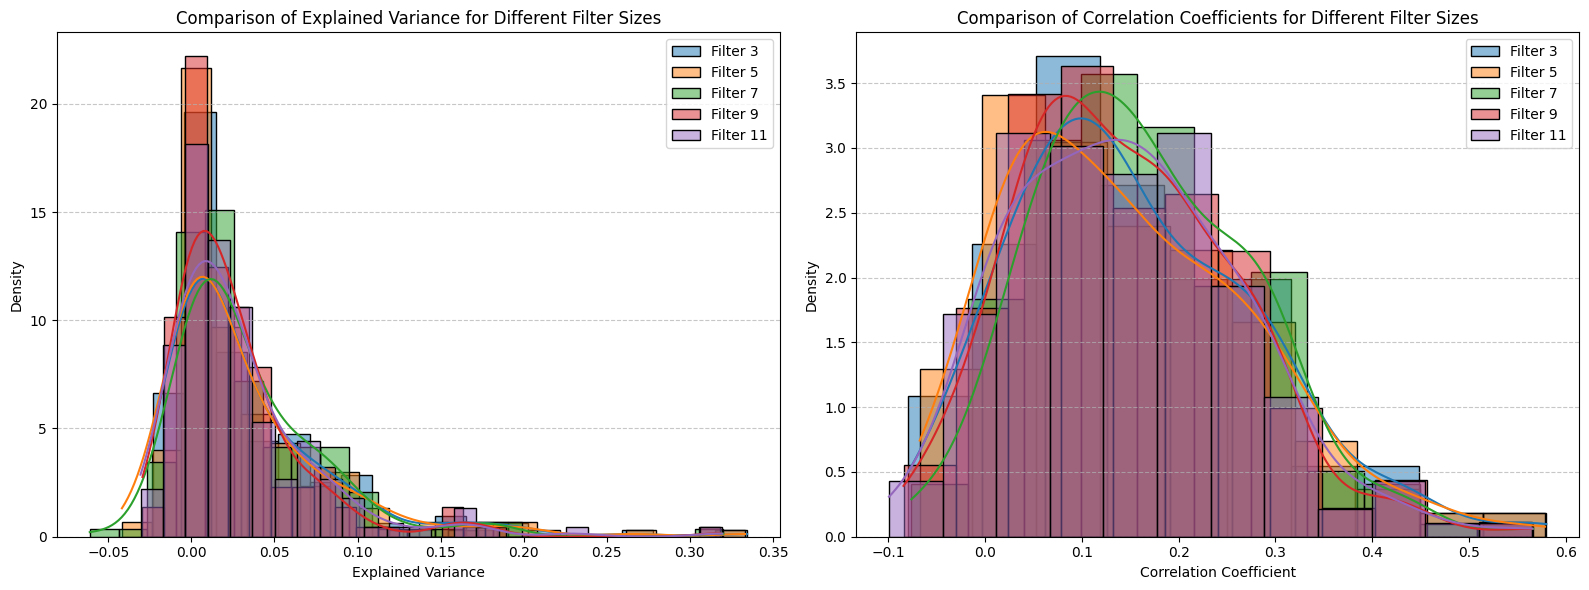

In [26]:
### Compare explained variances and correlations for different filter sizes
plt.figure(figsize=(16, 6))

# First subplot: Compare explained variances for different filter sizes
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
for f_size, metrics in results_filter_sizes.items():
    sns.histplot(metrics['ev'], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Explained Variance')
plt.ylabel('Density')
plt.title('Comparison of Explained Variance for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Compare correlation coefficients for different filter sizes
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
for f_size, metrics in results_filter_sizes.items():
    sns.histplot(metrics['corr'][0], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Comparison of Correlation Coefficients for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

Over the both metrics of explained variance of correlation, the filter size of 7 seems to be the best.

### Testing different number of feature maps

Similarly, we want to assess the most reasonable number of feature maps.

In [ ]:
### Test different number of feature maps
nb_of_feature_map_to_test = [32, 64, 128, 256]

results_feature_maps = {}

for nb_feature_map in nb_of_feature_map_to_test:
    print(f"\n=== Training with feature map of size {nb_feature_map} ===")
    
    # Define model with the given filter size
    model = ShallowConvNet(dims=[nb_feature_map], kernel_sizes=[5])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Create a new trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device='cuda'
    )

    # Train
    trainer.fit(epochs=10, early_stopping_patience=5)

    # Evaluate on validation set
    model_name = f'best_model{len(model.blocks)}_blocks.pth'
    model.load_state_dict(torch.load(model_name))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to('cuda')
            preds = model(x)
            y_pred.append(preds.cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)

    # Compute metrics
    corr_feature_maps = pearsonr(spikes_val, y_pred)
    mse_feature_maps = mean_squared_error(spikes_val, y_pred)
    ev_feature_maps = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')

    results_feature_maps[nb_feature_map] = {
        'corr': corr_feature_maps,
        'mse': mse_feature_maps,
        'ev': ev_feature_maps,
        'y_pred': y_pred
    }


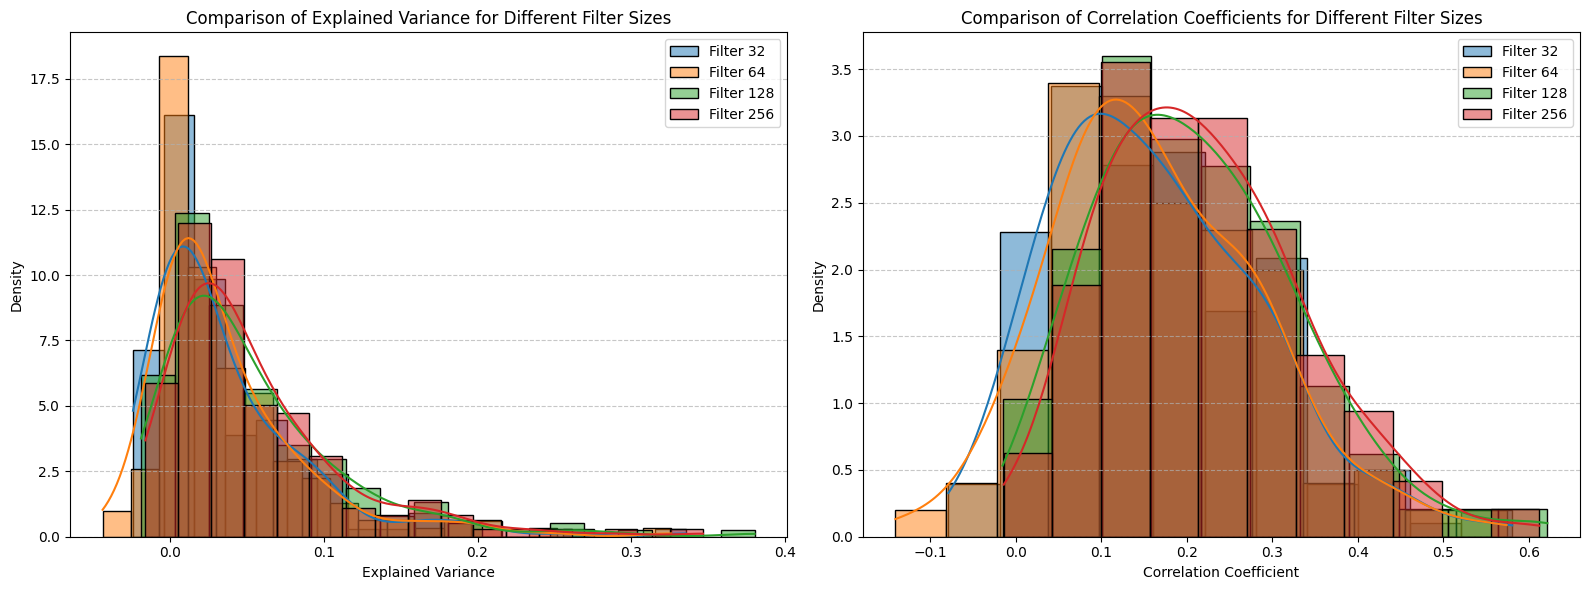

In [28]:
### Compare explained variances and correlations for different number of feature maps
plt.figure(figsize=(16, 6))

# First subplot: Compare explained variances for different filter sizes
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
for f_size, metrics in results_feature_maps.items():
    sns.histplot(metrics['ev'], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Explained Variance')
plt.ylabel('Density')
plt.title('Comparison of Explained Variance for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Compare correlation coefficients for different filter sizes
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
for f_size, metrics in results_feature_maps.items():
    sns.histplot(metrics['corr'][0], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Comparison of Correlation Coefficients for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

It seems that the filter of 256 is the best performing.

### Final 1 block model

In [ ]:
# Initialize components
model = ShallowConvNet(dims=[256], kernel_sizes=[7])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Create Trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device='cuda'
)

# Train
trainer.fit(epochs=50, early_stopping_patience=5)

In [31]:
# Predictions for the data driven model
model = ShallowConvNet(dims=[256, 256], kernel_sizes=[5, 5])
model = model.to('cuda')
model.load_state_dict(torch.load('best_model2_blocks.pth'))
model.eval()
y_pred_data_driven = []    
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to('cuda')
        preds = model(x)
        y_pred_data_driven.append(preds.cpu().numpy())
y_pred_data_driven = np.concatenate(y_pred_data_driven, axis=0)

C:\Users\charl\AppData\Local\Temp\ipykernel_11388\1808562699.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model2_blocks.pth'))


### Comparing with the task-driven model

In [16]:
# Predictions for the task driven model, read the data from the file
# Load the task-driven model predictions
y_pred_task_driven = np.load('best week6-part2 prediction.npz')['val_predictions']
y_pred_task_driven.shape, spikes_val.shape

((288, 168), (288, 168))

The mean of the correlation for the data driven model is 0.4544496536254883
The std of the correlation for the data driven model is 0.12553982436656952
The MSE for the data driven model is 0.10842834413051605


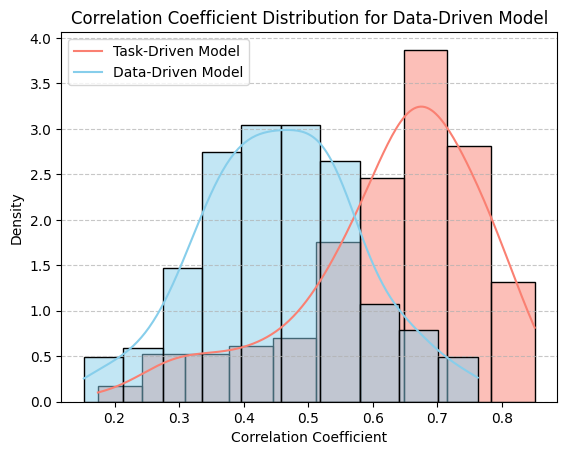

In [32]:
# Explained correlation
### For task driven model
lin_reg_results_task_driven = {'corr':{},'mse':{},'EV':{}}
lin_reg_results_task_driven['corr'] = pearsonr(spikes_val,y_pred_task_driven)
lin_reg_results_task_driven['mse'] = mean_squared_error(spikes_val, y_pred_task_driven)
lin_reg_results_task_driven['EV'] = explained_variance_score(spikes_val, y_pred_task_driven, multioutput='raw_values')

r_vals = lin_reg_results_task_driven['corr'].statistic
p_vals = lin_reg_results_task_driven['corr'].pvalue
confident_r_vals = r_vals[p_vals<0.05]

sns.histplot(confident_r_vals, bins=10,kde=True, stat='density',color='salmon')

### For data driven model
lin_reg_results_data_driven = {'corr':{},'mse':{},'EV':{}}
lin_reg_results_data_driven['corr'] = pearsonr(spikes_val, y_pred_data_driven)
lin_reg_results_data_driven['mse'] = mean_squared_error(spikes_val, y_pred_data_driven)
lin_reg_results_data_driven['EV'] = explained_variance_score(spikes_val, y_pred_data_driven, multioutput='raw_values')

r_vals = lin_reg_results_data_driven['corr'].statistic
p_vals = lin_reg_results_data_driven['corr'].pvalue
confident_r_vals = r_vals[p_vals<0.05]

sns.histplot(confident_r_vals, bins=10,kde=True, stat='density',color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Correlation Coefficient Distribution for Data-Driven Model')
plt.legend(['Task-Driven Model', 'Data-Driven Model'])

# Print the mean and std of the correlation and MSE for the data driven model
print('The mean of the correlation for the data driven model is {}'.format(np.mean(lin_reg_results_data_driven['corr'].statistic)))
print('The std of the correlation for the data driven model is {}'.format(np.std(lin_reg_results_data_driven['corr'].statistic)))
print('The MSE for the data driven model is {}'.format(lin_reg_results_data_driven['mse']))

The mean of the explained variance for the data driven model is 0.20845690369606018
The std of the explained variance for the data driven model is 0.12392178177833557


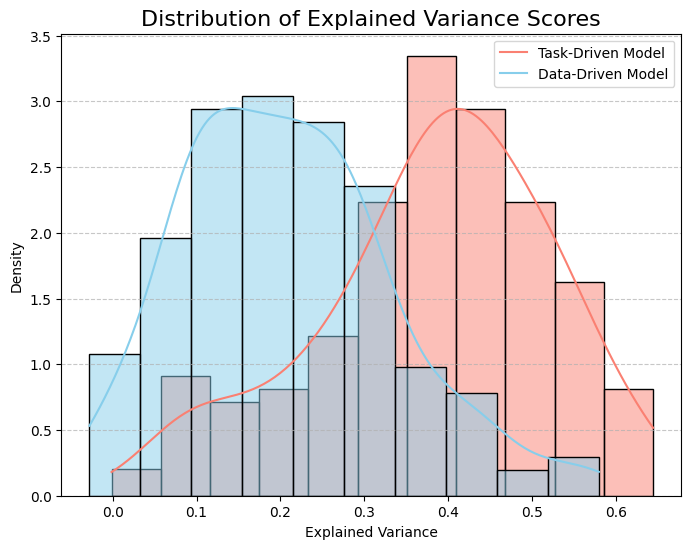

In [33]:
# Explained variance
plt.figure(figsize=(8, 6))

### For task driven model
sns.histplot(lin_reg_results_task_driven['EV'], kde=True, stat='density',color='salmon')
plt.title("Distribution of Explained Variance Scores", fontsize=16)
plt.xlabel("Explained Variance")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)


### For data driven model
sns.histplot(lin_reg_results_data_driven['EV'], kde=True, stat='density',color='skyblue')
plt.title("Distribution of Explained Variance Scores", fontsize=16)
plt.xlabel("Explained Variance")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Task-Driven Model', 'Data-Driven Model'])

# Print the mean and std of the explained variance for the data driven model
print('The mean of the explained variance for the data driven model is {}'.format(np.mean(lin_reg_results_data_driven['EV'])))
print('The std of the explained variance for the data driven model is {}'.format(np.std(lin_reg_results_data_driven['EV'])))

## Training a 2-block model

### Testing different filter sizes

In [ ]:
### Test different filter sizes
filter_sizes_to_test = [3, 5, 7, 9, 11]

results_filter_sizes = {}

for filter_size in filter_sizes_to_test:
    print(f"\n=== Training with filter size {filter_size} ===")
    
    # Define model with the given filter size
    model = ShallowConvNet(dims=[64, 64], kernel_sizes=[filter_size, filter_size])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Create a new trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device='cuda'
    )

    # Train
    trainer.fit(epochs=10, early_stopping_patience=5)

    # Evaluate on validation set
    model_name = f'best_model{len(model.blocks)}_blocks.pth'
    model.load_state_dict(torch.load(model_name))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to('cuda')
            preds = model(x)
            y_pred.append(preds.cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)

    # Compute metrics
    corr_filter_sizes = pearsonr(spikes_val, y_pred)
    mse_filter_sizes = mean_squared_error(spikes_val, y_pred)
    ev_filter_sizes = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')

    results_filter_sizes[filter_size] = {
        'corr': corr_filter_sizes,
        'mse': mse_filter_sizes,
        'ev': ev_filter_sizes,
        'y_pred': y_pred
    }


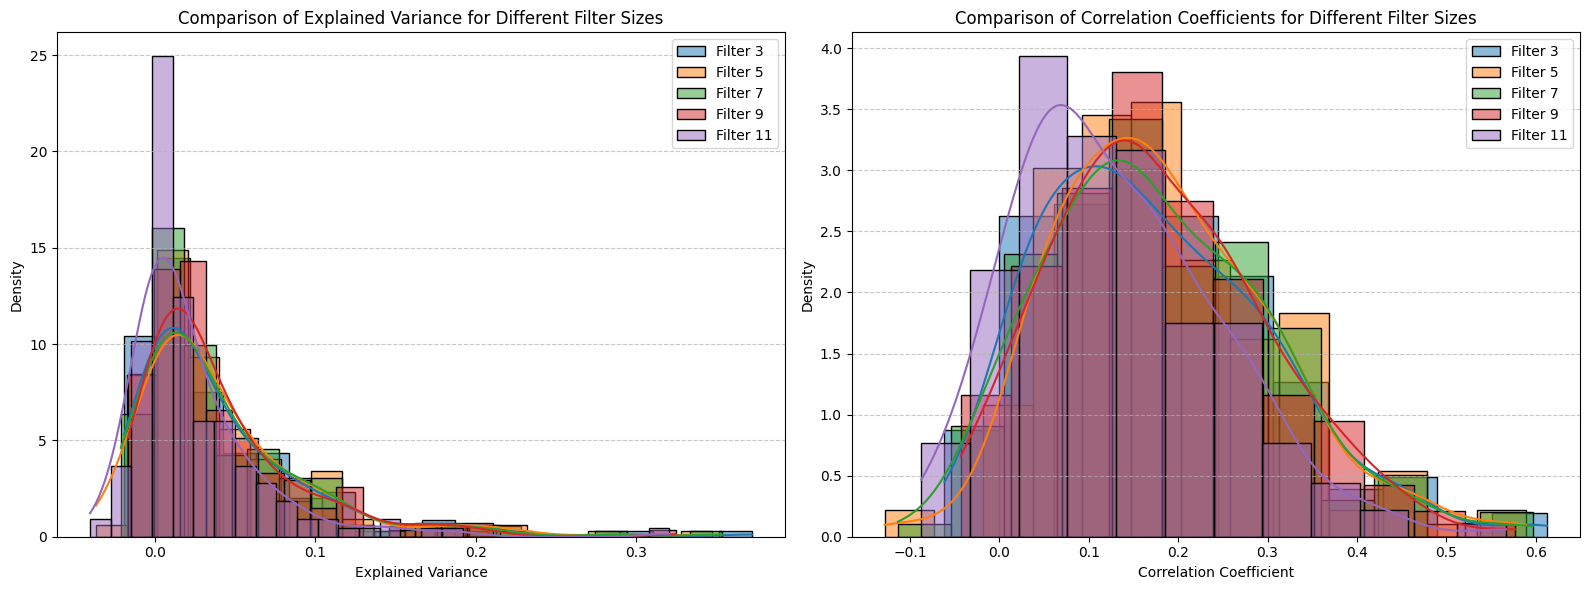

In [17]:
### Compare explained variances and correlations for different filter sizes
plt.figure(figsize=(16, 6))

# First subplot: Compare explained variances for different filter sizes
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
for f_size, metrics in results_filter_sizes.items():
    sns.histplot(metrics['ev'], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Explained Variance')
plt.ylabel('Density')
plt.title('Comparison of Explained Variance for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Compare correlation coefficients for different filter sizes
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
for f_size, metrics in results_filter_sizes.items():
    sns.histplot(metrics['corr'][0], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Comparison of Correlation Coefficients for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

It seems that a filter size of 5 gives the best correlation and explained variance.

### Testing different number of feature maps

In [ ]:
### Test different number of feature maps
nb_of_feature_map_to_test = [32, 64, 128, 256]

results_feature_maps = {}

for nb_feature_map in nb_of_feature_map_to_test:
    print(f"\n=== Training with feature map of size {nb_feature_map} ===")
    
    # Define model with the given filter size
    model = ShallowConvNet(dims=[nb_feature_map, nb_feature_map], kernel_sizes=[5, 5])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Create a new trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device='cuda'
    )

    # Train
    trainer.fit(epochs=10, early_stopping_patience=5)

    # Evaluate on validation set
    model_name = f'best_model{len(model.blocks)}_blocks.pth'
    model.load_state_dict(torch.load(model_name))
    model.eval()
    y_pred = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to('cuda')
            preds = model(x)
            y_pred.append(preds.cpu().numpy())
    y_pred = np.concatenate(y_pred, axis=0)

    # Compute metrics
    corr_feature_maps = pearsonr(spikes_val, y_pred)
    mse_feature_maps = mean_squared_error(spikes_val, y_pred)
    ev_feature_maps = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')

    results_feature_maps[nb_feature_map] = {
        'corr': corr_feature_maps,
        'mse': mse_feature_maps,
        'ev': ev_feature_maps,
        'y_pred': y_pred
    }


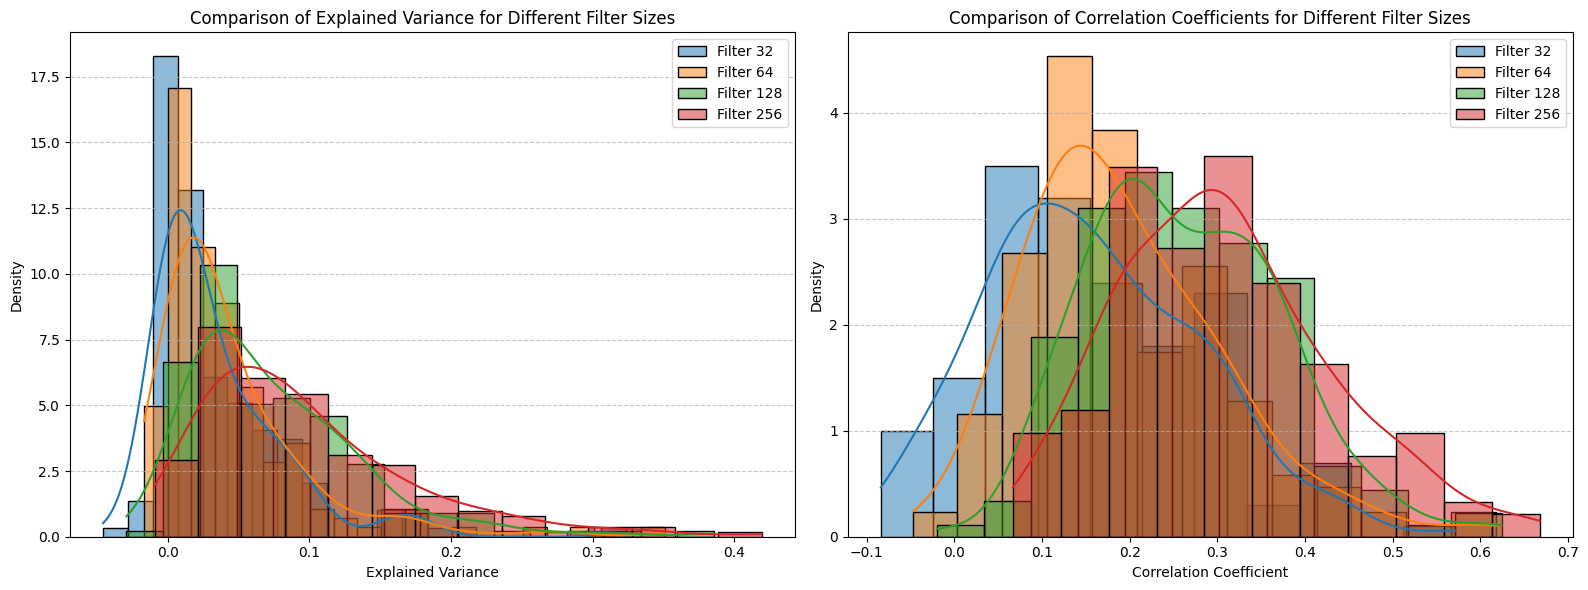

In [19]:
### Compare explained variances and correlations for different number of feature maps
plt.figure(figsize=(16, 6))

# First subplot: Compare explained variances for different filter sizes
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
for f_size, metrics in results_feature_maps.items():
    sns.histplot(metrics['ev'], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Explained Variance')
plt.ylabel('Density')
plt.title('Comparison of Explained Variance for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Compare correlation coefficients for different filter sizes
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
for f_size, metrics in results_feature_maps.items():
    sns.histplot(metrics['corr'][0], kde=True, stat='density', label=f'Filter {f_size}')

plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Comparison of Correlation Coefficients for Different Filter Sizes')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

This time, we see that a filter size of 256 is better. Out of computational considerations, we won't explore bigger filter sizes, but in theory we would like to assess when the filter size increase saturates, and does not increase the explained variance and correlation anymore.

### Final 2-blocks model

In [ ]:
# Initialize components
model = ShallowConvNet(dims=[256, 256], kernel_sizes=[5, 5])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Create Trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device='cuda'
)

# Train
trainer.fit(epochs=50, early_stopping_patience=5)

In [14]:
# Predictions for the data driven model
model = ShallowConvNet(dims=[256, 256], kernel_sizes=[5, 5])
model = model.to('cuda')
model.load_state_dict(torch.load('best_model2_blocks.pth'))
model.eval()
y_pred_data_driven = []    
with torch.no_grad():
    for x, _ in val_loader:
        x = x.to('cuda')
        preds = model(x)
        y_pred_data_driven.append(preds.cpu().numpy())
y_pred_data_driven = np.concatenate(y_pred_data_driven, axis=0)

C:\Users\charl\AppData\Local\Temp\ipykernel_11388\1808562699.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model2_blocks.pth'))


### Comparing with the task-driven model

The mean of the correlation for the data driven model is 0.4509155750274658
The std of the correlation for the data driven model is 0.1273135542869568
The MSE for the data driven model is 0.10761915147304535


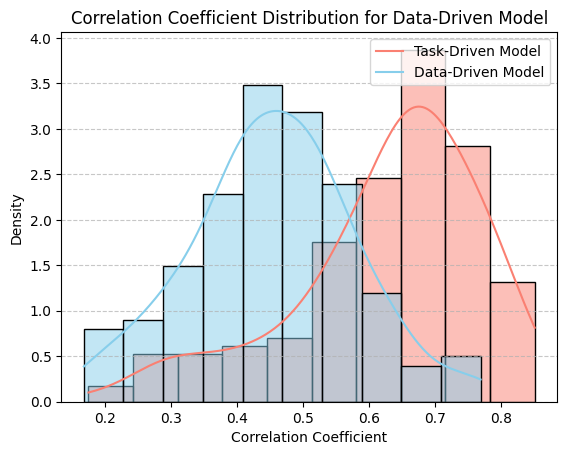

In [24]:
# Explained correlation
### For task driven model
lin_reg_results_task_driven = {'corr':{},'mse':{},'EV':{}}
lin_reg_results_task_driven['corr'] = pearsonr(spikes_val,y_pred_task_driven)
lin_reg_results_task_driven['mse'] = mean_squared_error(spikes_val, y_pred_task_driven)
lin_reg_results_task_driven['EV'] = explained_variance_score(spikes_val, y_pred_task_driven, multioutput='raw_values')

r_vals = lin_reg_results_task_driven['corr'].statistic
p_vals = lin_reg_results_task_driven['corr'].pvalue
confident_r_vals = r_vals[p_vals<0.05]

sns.histplot(confident_r_vals, bins=10,kde=True, stat='density',color='salmon')

### For data driven model
lin_reg_results_data_driven = {'corr':{},'mse':{},'EV':{}}
lin_reg_results_data_driven['corr'] = pearsonr(spikes_val, y_pred_data_driven)
lin_reg_results_data_driven['mse'] = mean_squared_error(spikes_val, y_pred_data_driven)
lin_reg_results_data_driven['EV'] = explained_variance_score(spikes_val, y_pred_data_driven, multioutput='raw_values')

r_vals = lin_reg_results_data_driven['corr'].statistic
p_vals = lin_reg_results_data_driven['corr'].pvalue
confident_r_vals = r_vals[p_vals<0.05]

sns.histplot(confident_r_vals, bins=10,kde=True, stat='density',color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Correlation Coefficient Distribution for Data-Driven Model')
plt.legend(['Task-Driven Model', 'Data-Driven Model'])

# Print the mean and std of the correlation and MSE for the data driven model
print('The mean of the correlation for the data driven model is {}'.format(np.mean(lin_reg_results_data_driven['corr'].statistic)))
print('The std of the correlation for the data driven model is {}'.format(np.std(lin_reg_results_data_driven['corr'].statistic)))
print('The MSE for the data driven model is {}'.format(lin_reg_results_data_driven['mse']))

The mean of the explained variance for the data driven model is 0.20845690369606018
The std of the explained variance for the data driven model is 0.12392178177833557


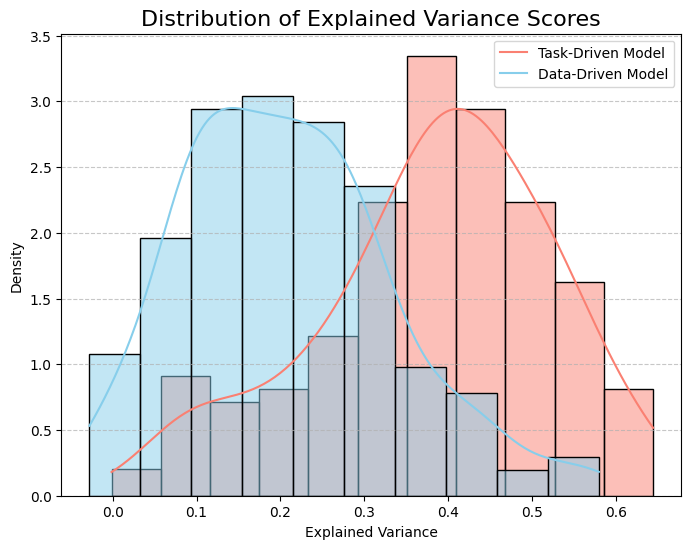

In [18]:
# Explained variance
plt.figure(figsize=(8, 6))

### For task driven model
sns.histplot(lin_reg_results_task_driven['EV'], kde=True, stat='density',color='salmon')
plt.title("Distribution of Explained Variance Scores", fontsize=16)
plt.xlabel("Explained Variance")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)


### For data driven model
sns.histplot(lin_reg_results_data_driven['EV'], kde=True, stat='density',color='skyblue')
plt.title("Distribution of Explained Variance Scores", fontsize=16)
plt.xlabel("Explained Variance")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Task-Driven Model', 'Data-Driven Model'])

# Print the mean and std of the explained variance for the data driven model
print('The mean of the explained variance for the data driven model is {}'.format(np.mean(lin_reg_results_data_driven['EV'])))
print('The std of the explained variance for the data driven model is {}'.format(np.std(lin_reg_results_data_driven['EV'])))